<a href="https://colab.research.google.com/github/sugiyama404/forecast_sp500/blob/main/ex_fc1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import LSTM,GRU

from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from google.colab import drive

In [2]:
# データ読み込み
drive.mount('/content/drive/')
nov_dir = 'Colab Notebooks/dataset/'  # このフォルダへのパス
nov_path = '/content/drive/My Drive/' + nov_dir + 'data_csv_sp500.csv'

df = pd.read_csv(nov_path)
df['Date'] = pd.to_datetime(df['Date'], format = '%Y-%m-%d')

#データの標準化
df['SP500'] = preprocessing.scale(df['SP500'])

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [7]:
#訓練、テストデータの作成
maxlen = 10
X, Y = [], []
for i in range(len(df) - maxlen):
    X.append(df[['SP500']].iloc[i:(i+maxlen)].values)
    Y.append(df[['SP500']].iloc[i+maxlen].values)
X=np.array(X)
Y=np.array(Y)

# 訓練用のデータと、テスト用のデータに分ける
N_train = int(len(df) * 0.8)
N_test = len(df) - N_train
X_train, X_test, y_train, y_test = \
    train_test_split(X, Y, test_size=N_test, shuffle = False)

In [8]:
#学習

# 隠れ層の数などを定義: 隠れ層の数が大きいほど精度が上がる?
n_in = 1 # len(X[0][0])
n_out = 1 # len(Y[0])
n_hidden = 300

model = Sequential()
model.add(GRU(n_hidden,
               batch_input_shape=(None, maxlen, n_in),
               kernel_initializer='random_uniform',
               return_sequences=False))
model.add(Dense(n_in, kernel_initializer='random_uniform'))
model.add(Activation("linear"))

opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(loss = "mean_squared_error", optimizer=opt)

early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=1)
hist = model.fit(X_train, y_train, batch_size=maxlen, epochs=50,
                 callbacks=[early_stopping])

Epoch 1/50
141/141 [==============================] - 5s 20ms/step - loss: 0.0281
Epoch 2/50
141/141 [==============================] - 3s 19ms/step - loss: 1.3240e-04
Epoch 3/50
141/141 [==============================] - 3s 19ms/step - loss: 1.2272e-04
Epoch 4/50
141/141 [==============================] - 3s 19ms/step - loss: 1.4520e-04
Epoch 5/50
141/141 [==============================] - 3s 19ms/step - loss: 1.0782e-04
Epoch 6/50
141/141 [==============================] - 3s 20ms/step - loss: 2.0979e-04
Epoch 7/50
141/141 [==============================] - 3s 20ms/step - loss: 1.0797e-04
Epoch 8/50
141/141 [==============================] - 3s 20ms/step - loss: 1.4207e-04
Epoch 9/50
141/141 [==============================] - 3s 20ms/step - loss: 1.1910e-04
Epoch 10/50
141/141 [==============================] - 3s 19ms/step - loss: 1.1292e-04
Epoch 11/50
141/141 [==============================] - 3s 20ms/step - loss: 1.1477e-04
Epoch 12/50
141/141 [==============================] - 3

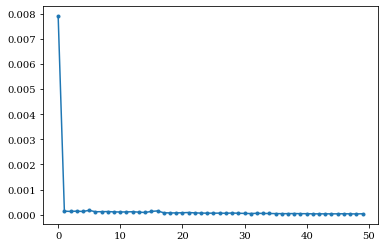

<Figure size 432x288 with 0 Axes>

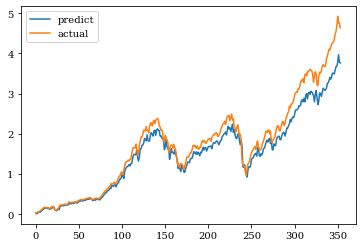

In [11]:
# 損失のグラフ化
loss = hist.history['loss']
epochs = len(loss)
plt.rc('font', family='serif')

fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(range(epochs), loss, marker='.', label='loss(training data)')
nov_dir = 'Colab Notebooks/workspace/'  # このフォルダへのパス
nov_path = '/content/drive/My Drive/' + nov_dir + 'ex_fc1_1.png'

plt.savefig(nov_path)
plt.show()
plt.close('all')

# 予測結果
predicted = model.predict(X_test)
result = pd.DataFrame(predicted)
result.columns = ['predict']
result['actual'] = y_test
plt.figure()
result.plot()

nov_dir = 'Colab Notebooks/workspace/'  # このフォルダへのパス
nov_path = '/content/drive/My Drive/' + nov_dir + 'ex_fc1_2.png'

plt.savefig(nov_path)
plt.show()
plt.close('all')
